In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [3]:
df = pd.read_csv("compiled_data_toclassify.csv",index_col=None, header=0)
df=df.drop(df.columns[0],1)

In [20]:
slicit=(df['response_type']=='asker') 
cols = [col for col in df.columns if 'diag_' in col]
col_name = np.array([col.split('_')[1] for col in df.columns if 'diag_' in col])
diag = (df.loc[slicit,cols].as_matrix()>0)

In [8]:
synopses = df.loc[slicit,'response'].tolist()
titles = df.loc[slicit,'label'].tolist()

In [9]:
print titles[:10] #first 10 titles

['eczema', 'angiomas', 'warts', 'antihistamines', 'contact dermatitis', 'intertrigo', 'cellulitis', 'antihistamines', 'antihistamines', 'pyogenic granuloma']


In [13]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [14]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [15]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [16]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'

there are 12068 items in vocab_frame


In [17]:
print vocab_frame.head()

     words
i        i
have  have
a        a
rash  rash
on      on


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 1.7 s, sys: 16 ms, total: 1.72 s
Wall time: 1.71 s
(126, 16)


In [19]:
terms = tfidf_vectorizer.get_feature_names()

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [22]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 212 ms, sys: 8 ms, total: 220 ms
Wall time: 231 ms


In [ ]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

#joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [24]:
films = { 'title': titles, 'synopsis': synopses, 'cluster': clusters }

frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'synopsis', 'cluster'])

In [26]:
frame.cluster.value_counts()

3    36
0    32
2    22
4    18
1    18
Name: cluster, dtype: int64

In [38]:
print("Top terms per cluster:")
print
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
cluster_names={}

for i in range(num_clusters):
    print("Cluster %d words:" % i)
    
    words=''
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        new_word=vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')
        words=words+new_word+', '
        print(' %s,' % new_word)
    cluster_names[i]=words
    print #add whitespace
    print #add whitespace
    
    print("Cluster %d titles:" % i)
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title)
    print #add whitespace
    print #add whitespace

Top terms per cluster:

Cluster 0 words:
 's,
 itchy,
 any,
 bumps,
 n't,
 help,


Cluster 0 titles:
 contact dermatitis,
 antihistamines,
 eczema,
 cysts,
 warts,
 herpes,
 boils,
 sebaceous cyst,
 keratosis pilaris,
 hives,
 pityriasis alba,
 hair removal,
 contact dermatitis,
 liposuction,
 boils,
 contact dermatitis,
 biopsy,
 contact dermatitis,
 contact dermatitis,
 hair removal,
 hives,
 scabies,
 hives,
 antihistamines,
 contact dermatitis,
 tinea,
 hives,
 eczema,
 hives,
 eczema,
 contact dermatitis,
 eczema,


Cluster 1 words:
 skin,
 day,
 like,
 thank,
 's,
 help,


Cluster 1 titles:
 intertrigo,
 dry skin,
 warts,
 atypical moles,
 acne,
 sebaceous cyst,
 atopic dermatitis,
 acne,
 atopic dermatitis,
 acne,
 lichen planus,
 chemical peels,
 biopsy,
 intertrigo,
 allergic contact dermatitis,
 cysts,
 atopic dermatitis,
 skin care,


Cluster 2 words:
 red,
 just,
 bumps,
 like,
 started,
 skin,


Cluster 2 titles:
 antihistamines,
 cellulitis,
 atopic dermatitis,
 folliculi

In [32]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

()
()


In [39]:


#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

    
#set up cluster names using a dict
cluster_names



{0: "'s, itchy, any, bumps, n't, help, ",
 1: "skin, day, like, thank, 's, help, ",
 2: 'red, just, bumps, like, started, skin, ',
 3: "n't, years, like, noticed, thank, help, ",
 4: "itch, red, day, like, bumps, n't, "}

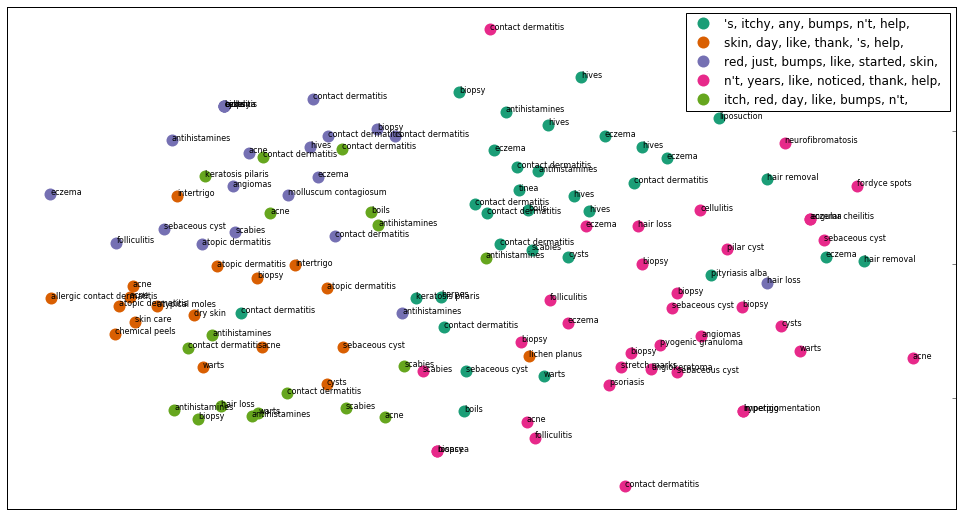

In [42]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [1]:
df

NameError: name 'df' is not defined